# 0. Imports

In [1]:
import os
import classes as c
import importlib

_RAW_DIR = os.path.join('.', 'samples', 'raws')
_ROOT_DIR = os.path.join('.', 'samples', 'processed')

# 1. Identifying Valid Participants, Converting Raw Filenames to Correct Naming Formats

In [5]:
importlib.reload(c)
experiment = c.Experiment(_RAW_DIR, _ROOT_DIR, verbose=False)
experiment.initialize_participants(verbose=False)

PI1:   0%|          | 0/14 [00:00<?, ?it/s]

P13: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]   

# 2. Callibration

In [6]:
importlib.reload(c)

outnames = [
    os.path.join(experiment.root_dir, 'calibration_timelines.png'),
    os.path.join(experiment.root_dir, 'calibration_timelines.pdf')
]
c.plot_calibration_timelines(experiment.pdirs,  outname=outnames, show=False)

P13: 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]   


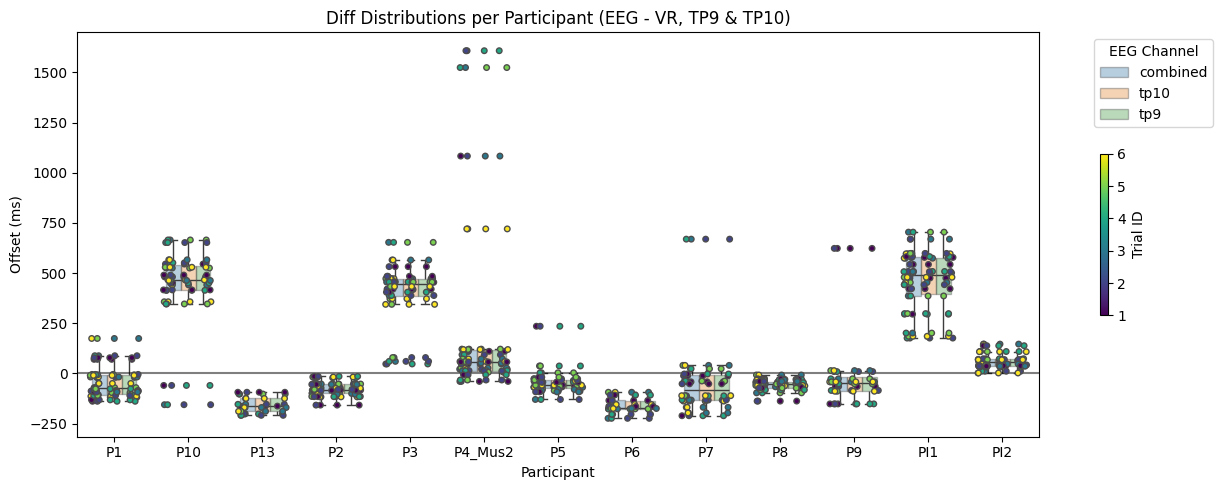

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   offset    
No. Observations:   478       Method:               REML      
No. Groups:         13        Scale:                35669.5587
Min. group size:    18        Log-Likelihood:       -3200.9924
Max. group size:    46        Converged:            Yes       
Mean group size:    36.8                                      
--------------------------------------------------------------
                  Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept          63.525   66.685 0.953 0.341 -67.174 194.225
tid                 4.921    5.190 0.948 0.343  -5.252  15.093
Group Var       52540.217  143.794                            
Group x tid Cov   400.115    8.691                            
tid Var             5.686    1.000                            



In [7]:
importlib.reload(c)

"""
- Context: between-subject variability with a within-subject time trend. 
    - Simple correlations (Pearson or Spearman) on pooled data are invalid
    - Even averaging across participants can be misleading
- Problem: need a model that separates:
    1. baseline differences between participants
    2. time (trial) effects within participants
- 2 Potential Solutions:
    1. Mixed-Effects Modeling:
        - random intercepts → each participant has their own baseline offset
        - fixed effect of tid → shared time trend across participants
    2. Random Slopes:
        - Maybe participants change at different rates over time?
- Inspiration: https://mfviz.com/hierarchical-models/
"""

outnames = [
    os.path.join(experiment.root_dir, 'blink_offsets.png'),
    os.path.join(experiment.root_dir, 'blink_offsets.pdf')
]
offsets = c.plot_offsets(experiment.participants, plot_type='box', hue_feature='channel', outname=outnames, show=True)
#c.mixed_effects(offsets[offsets['channel']=='combined'])
c.random_slopes(offsets[offsets['channel']=='combined'])


- tid coefficient → average change in offset per trial
- p-value for tid → whether time trend exists
- Group variance → magnitude of between-participant differences

# Debugging

In [ ]:
c.plot_calibration_with_peaks(experiment)

In [46]:
for p in experiment.participants:
    display(p.offset_medians)

,channel,offset_median
0,combined,490.0
1,tp10,490.0
2,tp9,490.0


,channel,offset_median
0,combined,443.5
1,tp10,443.5
2,tp9,443.5


,channel,offset_median
0,combined,-81.0
1,tp10,-81.0
2,tp9,-81.0


,channel,offset_median
0,combined,-58.0
1,tp10,-58.0
2,tp9,-58.0


,channel,offset_median
0,combined,466.0
1,tp10,466.0
2,tp9,466.0


,channel,offset_median
0,combined,57.0
1,tp10,57.0
2,tp9,57.0


,channel,offset_median
0,combined,-81.5
1,tp10,-81.5
2,tp9,-81.5


,channel,offset_median
0,combined,-47.0
1,tp10,-47.0
2,tp9,-47.0


,channel,offset_median
0,combined,59.0
1,tp10,59.0
2,tp9,59.0


,channel,offset_median
0,combined,-53.0
1,tp10,-53.0
2,tp9,-53.0


,channel,offset_median
0,combined,-170.0
1,tp10,-170.0
2,tp9,-170.0


,channel,offset_median
0,combined,-74.0
1,tp10,-74.0
2,tp9,-74.0


,channel,offset_median
0,combined,-163.0
1,tp10,-163.0
2,tp9,-163.0


In [ ]:
# Packages
import os
import shutil
from pathlib import Path
from typing import Iterable, List, Tuple, Dict
import importlib

# Custom Components
from components import file_handling as fh
from components import separate
import classes as c

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Packages
import os
import shutil
from pathlib import Path
from typing import Iterable, List, Tuple, Dict
import importlib

# Custom Components
from components import file_handling as fh
from components import separate
import classes as c

# Reload components
importlib.reload(fh)
importlib.reload(separate)
importlib.reload(c)

_RAWS_DIR = os.path.join('.', 'samples', 'raws')
_ROOT_DIR = os.path.join('.', 'samples', 'processed')
_EXPECTED_FILES = [
#   'calibration_test.csv',     # <-- Early participants won't have this one
    'calibration_test_1.csv',
    'calibration_test_2.csv',
    'calibration_test_3.csv',
    'calibration_test_4.csv',
    'calibration_test_5.csv',
    'calibration_test_6.csv',
    'calibration_test_7.csv',
    'eye.csv',
    'eeg-rest.csv',
    'eeg-vr.csv',
    'pedestrians.csv'
]
_FILENAME_REMAP = {
    'calibration_test.csv':     'calibration_0.csv',
    'calibration_test_1.csv':   'calibration_1.csv',
    'calibration_test_2.csv':   'calibration_2.csv',
    'calibration_test_3.csv':   'calibration_3.csv',
    'calibration_test_4.csv':   'calibration_4.csv',
    'calibration_test_5.csv':   'calibration_5.csv',
    'calibration_test_6.csv':   'calibration_6.csv',
    'calibration_test_7.csv':   'calibration_7.csv',
    'eye.csv':                  'eye.csv',
    'eeg-rest.csv':             'eeg_rest.csv',
    'eeg-vr.csv':               'eeg_vr.csv',
    'pedestrians.csv':          'pedestrians.csv'
}

# Identify valid and invalid participant directories
present, missing = separate.identify_valid_participants(_RAWS_DIR, _EXPECTED_FILES)
print("Present:")
for p in present: print(f'\t{p}')
print("Missing:")
for p in missing: print(f'\t{p}')

# Copy and Paste valid participants
pdirs = separate.copy_and_rename(present, _FILENAME_REMAP, _ROOT_DIR)
print("New Source Files:")
for p in pdirs: print(f'\t{p}')


In [ ]:
importlib.reload(c)

experiment = c.Experiment(
    _ROOT_DIR, 
    pdirs, 
    verbose=False )          # Define experiment

In [ ]:
importlib.reload(separate)

_TRIAL_NAMES = [
    "Activation",
    "Trial-ApproachAudio Start", 
    "Trial-BehindAudio Start", 
    "Trial-Behind Start", 
    "Trial-AlleyRunnerAudio Start", 
    "Trial-AlleyRunner Start", 
    "Trial-Approach Start"
]

for pdir in pdirs: 
    print(separate.identify_calibration_order(pdir))

# 2. File Sorting into Trials

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
pd.options.mode.chained_assignment = None  # default='warn'

from components import eeg_handling as eh, plot_handling as ph
importlib.reload(eh)
importlib.reload(ph)
_TRIAL_NAMES = [
    "Trial-ApproachAudio Start", 
    "Trial-BehindAudio Start", 
    "Trial-Behind Start", 
    "Trial-AlleyRunnerAudio Start", 
    "Trial-AlleyRunner Start", 
    "Trial-Approach Start"
]

_CALIBRATION_COLUMNS = [
    'unix_ms', 
    'frame', 
    'rel_timestamp',
    'event', 
    'overlap_counter'
]

# 
def read_calibration_file(_F:str, correction:bool=True):
    # Read the file
    df = pd.read_csv(_F)

    # Correction, if necessary
    if correction: 
        df = df.iloc[:, :len(_CALIBRATION_COLUMNS)]
        df.columns = _CALIBRATION_COLUMNS

# SEPARATE FILES INTO TRIALS
def separate_into_trials( pdirs: Iterable[str] ) -> None:
    # Iterate through eahch participant directory
    pbar = tqdm(pdirs)
    for pdir in pbar:
        # Initialize Path and pbar, update pbar
        ppath = Path(pdir)
        pid = os.path.basename(pdir)
        pbar.set_description(pid)
        # Create the outpuyt directory for the rest state
        output_dir = fh.mkdirs(os.path.join(pdir, 'rest/'))
        # Read the eeg_rest data 
        eeg, blinks = eh.read(os.path.join(pdir, 'eeg_rest.csv'))
        raw, processed = eh.separate(eeg)
        #  Save rest data
        raw.to_csv(os.path.join(output_dir, 'raw.csv'), index=False)
        processed.to_csv(os.path.join(output_dir, 'processed.csv'), index=False)
        blinks.to_csv(os.path.join(output_dir, 'muse_blinks.csv'), index=False)

        # Render Eye-To-Calibration Files
        calibration_files = [str(cal_file) for cal_file in sorted(ppath.glob("calibration_*.csv"))]
        eye_file = os.path.join(pdir, 'eye.csv')
        ph.eye_calibration_timeline(
            pid, 
            eye_file, 
            calibration_files, 
            show = False,
            outpath = os.path.join(pdir, 'eye_to_cal_timeline.png')
        )
        



separate_into_trials(pdirs)